In [1]:
import numpy as np
import sunode
import sympy as sym
import matplotlib.pyplot as plt
import pandas as pd

import sunode.symode.paramset
import sunode.symode.problem
import sunode.wrappers.as_aesara

import aesara
import aesara.tensor as aet

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


### Define ode using sympy and aesara

In [2]:
b = aet.dvector('b')
d = aet.dvector('d')

def rhs(t, y, params):
    return {
        'a': params.c.d * y.a + params.f[20],
        'b': {
            'c': [3., 4.],
        }
    }


solution, problem, solver = sunode.wrappers.as_aesara.solve_ivp(
    t0=0,
    y0={
        'a': (np.arange(3, dtype=float) + d[0] ** 2, 3),
        'b': {
            'c': (b ** 3, 2),
        }
    },
    params={
        'c': {
            'd': (d, 3),
        },
        'f': np.linspace(0, 1, 50),
    },
    tvals=np.arange(20) / 100,
    rhs=rhs,
)

In [3]:
problem.make_jac_dense(debug=True)

import numba
import numpy
import scipy


@numba.njit(fastmath=True)
def logaddexp(a, b):
    min_val = fmin(a, b)
    max_val = fmax(a, b)
    return max_val + log1p(exp(min_val - max_val))


@numba.njit(fastmath=True, error_model='numpy')
def compute(_out, time, state, params):
    _out[:] = 0
    _out[0, 0] = params.c.d[0,]
    _out[1, 1] = params.c.d[1,]
    _out[2, 2] = params.c.d[2,]



CPUDispatcher(<function SympyOde.make_jac_dense.<locals>.jac_dense at 0x7f533f394200>)

In [4]:
problem.make_sundials_jac_dense()

<Numba C callback 'Ode.make_sundials_jac_dense.<locals>.jac_dense_wrapper'>

In [3]:
tvals = np.arange(20) / 100
t0 = 0
y0 = np.ones(problem.n_states)
solver.set_params(np.ones((), dtype=problem.params_dtype))

In [4]:
y_out, grad_out, lamda_out = solver.make_output_buffers(tvals)
grads = np.ones_like(y_out)

In [5]:
%%timeit
solver.solve_forward(t0, tvals, y0, y_out)
solver.solve_backward(tvals[-1], t0, tvals, grads, grad_out, lamda_out)

1.25 ms ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [78]:
val = (solution ** 2).sum()
grads = aet.grad(val, [b, d])

In [79]:
func = aesara.function([b, d], [val] + grads)
func2 = aesara.function([b, d], [val])

In [80]:
np.random.seed(42)
b = np.random.randn(2)
d = np.random.randn(3)

In [81]:
%timeit func(b, d)
%timeit func2(b, d)

1.55 ms ± 2.63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
180 µs ± 324 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [82]:
func(b, d)

[array(185.95454144),
 array([12.06638293,  0.86567236]),
 array([252.23687613,  12.10402814,  21.63579496])]

In [86]:
h = 1e-6
b_ = b.copy()
b_[0] += h
(func(b_, d)[0] - func(b, d)[0]) / h

12.06641837825373

In [88]:
h = 1e-6
d_ = d.copy()
d_[2] += h
(func(b, d_)[0] - func(b, d)[0]) / h

21.63579725333875

### Define ode using sympy

In [6]:
coords = {
    'position': pd.Index(['pos1', 'pos2', 'pos3'])
}

# Define parameters of the ode.
params = {
    'a': (),
    'b': (),
    'c': (),
    'd': (),
    'f': {
        'g': 'position'
    }
}

# Declare state variables
states = {
    'x': {
        'a': (),
        'b': (0,),
    },
    'y': 'position',
}

# Define the right hand side of the ode
def rhs_sympy(t, y, params):
    return {
        'x': {
            'a': y.y[0] * params.d,
            'b': [],
        },
        'y': {
            'pos1': 0,
            'pos2': 1,
            'pos3': 2,
        }
    }

ode = sunode.symode.problem.SympyOde(params, states, rhs_sympy, [('d',), ('a',)], coords=coords)

In [7]:
func = ode.make_rhs()

In [8]:
p = ode.make_user_data()
y = np.ones((1,), dtype=ode.state_dtype)[0]
out = y[None].view(np.float64).copy()

In [9]:
%timeit func(out, 0.1, y, p)

2.04 µs ± 13.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [38]:
func_ = list(func.overloads.values())[0]

In [9]:
import numba

In [9]:
p = ode.make_user_data()
state_dtype = ode.state_dtype
y = np.ones((1,), dtype=state_dtype)[0]
out = np.zeros(4,)

@numba.njit
def foo(out):
    foo = out.view(state_dtype)
    return foo.x.a.sum()
    for _ in range(1000):
        func(out, 0.1, y, p)
    return out.sum()

In [10]:
foo(out)

0.0

In [11]:
p = ode.make_user_data()
state_dtype = ode.state_dtype
y = np.ones((1,), dtype=state_dtype)[0]
out = np.zeros(4,)

@numba.njit
def foo(out):
    for _ in range(1000):
        func(out, 0.1, y, p)
    return out.sum()

In [10]:
tvals = np.linspace(0, 10, 20)
y0 = np.ones(ode.n_states)

### Solve without gradients

In [11]:
import numba

47 µs ± 387 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


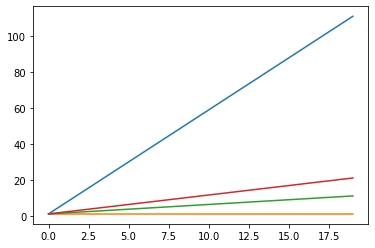

In [12]:
solver = sunode.solver.Solver(ode)
solver.set_params_dict({
    'a': 99,
    'b': 0.22,
    'c': 0.11,
    'd': 11,
    'f': {
        'g': np.array([1., 1., 1.])
    }
})
out = solver.make_output_buffers(tvals)
solver.solve(0, tvals, y0, out)
%timeit solver.solve(0, tvals, y0, out)
plt.plot(out);

In [11]:
y0.view(ode.state_dtype)[0]

((1., []), [1., 1., 1.])

### Solve with sensitivities

In [12]:
sens0 = np.zeros((ode.n_params, ode.n_states))

In [13]:
solver = sunode.solver.Solver(ode, compute_sens=True, sens_mode='simultaneous')
solver.set_params_dict({
    'a': 99,
    'b': 0.22,
    'c': 0.11,
    'd': 11,
    'f': {
        'g': np.array([1., 1., 1.])
    }
})
out, sens_out = solver.make_output_buffers(tvals)
%timeit solver.solve(0, tvals, y0, out, sens0=sens0, sens_out=sens_out)
plt.plot(sens_out[:, 1, 0]);

AttributeError: 'SympyOde' object has no attribute '_sym_fixed'

### Solve with adjoint

In [13]:
solver = sunode.solver.AdjointSolver(ode)
out, grad_out, lamda_out = solver.make_output_buffers(tvals)
solver.set_params_dict({
    'a': 99,
    'b': 0.22,
    'c': 0.11,
    'd': 11,
    'f': {
        'g': np.array([1., 1., 1.])
    }
})

grads = np.ones(out.shape)
grads[:, 0] = 0

In [14]:
%%timeit
solver.solve_forward(0, tvals, y0, out)
solver.solve_backward(tvals[-1], 0, tvals, grads, grad_out, lamda_out)

265 µs ± 1.17 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [73]:
#solver.as_xarray(tvals, out)

### Integrate into aesara and check gradients

In [10]:
tvals = np.arange(1, 10)

In [11]:
params = aet.dvector('params')
y0 = aet.dvector('y0')
solve_ode = sunode.wrappers.as_aesara.SolveODEAdjoint(solver, 0, tvals)
solution = solve_ode(y0, params)

loss = (solution ** 2).sum()
grad_p, grad_y0 = aet.grad(loss, [params, y0])
func = aesara.function([y0, params], [loss, grad_p, grad_y0])

# Explicit solution
loss = ((
    ((0.5 * tvals ** 2 * params[1] + tvals * y0[1]) + y0[0]) ** 2
    + (tvals * params[1] + y0[1]) ** 2
)).sum()
grad_p, grad_y0 = aet.grad(loss, [params, y0])

func2 = aesara.function([y0, params], [loss, grad_p, grad_y0])

In [12]:
p = np.random.randn(3)
y0 = np.random.randn(2)
func(y0, p)

[array(2799.56607648),
 array([   0.        , 6787.19817836,    0.        ]),
 array([ 241.49532577, 1759.40589498])]

In [13]:
func2(y0, p)

[array(2799.56607648),
 array([   0.        , 6787.19817831,    0.        ]),
 array([ 241.49532577, 1759.40589498])]

In [14]:
eps = 1e-8
h = np.zeros_like(y0)
h[0] += eps
a = func(y0, p)
b = func(y0 + h, p)

In [15]:
print((b[0] - a[0]) / h)
print(a[2])

[241.4951723         inf]
[ 241.49532577 1759.40589498]


In [16]:
eps = 1e-8
h = np.zeros_like(p)
h[1] += eps
a = func(y0, p)
b = func(y0, p + h)

In [17]:
print((b[0] - a[0]) / h)
print(a[1])

[          inf 6787.19829921           inf]
[   0.         6787.19817836    0.        ]


### Use in PyMC

In [18]:
import pymc as pm

with pm.Model() as model:
    params = pm.Normal('params', sigma=10, shape=ode.n_params)
    y0 = pm.Normal('y0', shape=ode.n_states)
    
    solve_ode = sunode.wrappers.as_aesara.SolveODEAdjoint(solver, 0, tvals)
    mu = solve_ode(y0, params)
    error = 0.8 * np.random.randn(len(tvals))
    pm.Normal('y', mu=mu[:, 0], sigma=0.8, observed=tvals ** 2 + tvals + 5 + error)
    
    trace = pm.sample(chains=2, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y0, params]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:33<00:00, 59.19draws/s] 


In [19]:
with model:
    tr = pm.sample_posterior_predictive(trace)

100%|██████████| 1000/1000 [00:00<00:00, 1691.56it/s]


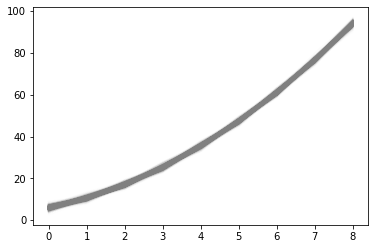

In [20]:
plt.plot(tr['y'].T, color='grey', alpha=0.01);

In [21]:
import seaborn as sns

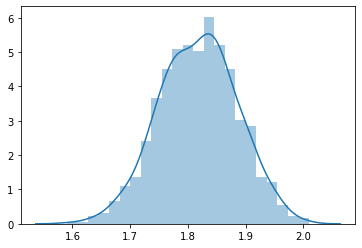

In [22]:
sns.distplot(trace['params'][:, 1])

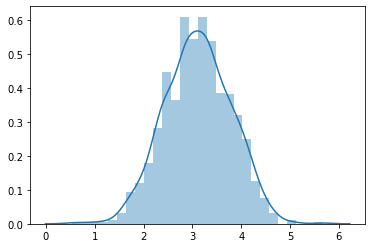

In [23]:
sns.distplot(trace['y0'][:, 0])